# Title:Supervising rain&snow or not 

    name:
        Bingyu Song    A20364641
        Xin Liu        A20353208
        Zhipeng liu    A20355209

project Description:
    we are trying to use last years weather condition to supervise if some day would rain,sonw or not.
    The data we got is about Chicago last 10 years weather from  'https://www.wundrground.com/history/',using some meatheds in scrapy.
    
    
    

1) We collect the metadata from "https://www.wunderground.com/" and download it by scrapy.

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt 
from collections import Counter
import numpy as np
import matplotlib.patches as mpatches
import scrapy
import requests
import os

In [2]:
class QuotesSpider(scrapy.Spider):
    name = "weather"

    def start_requests(self):
        urls = ['https://www.wunderground.com/history/airport/KORD/2006/1/1/MonthlyHistory.html']
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)

    def parse(self, response):
        page = response.css("h2.history-date::text").extract_first()
        filename = '%s.txt' % page
        target=response.css("div.obs-table-footer a::attr(href)").extract_first()
        target=response.urljoin(target)
        result=requests.get(target)
        f=open(filename, 'w+')
        f.write(result.text)
        f.close()
        next=response.css("div.next-link a::attr(href)").extract_first()
        target=response.css("div.obs-table-footer").extract_first()
        if target is not None:
            next_page = response.urljoin(next)
            yield scrapy.Request(next_page, callback=self.parse)



    2)process data(Considering the convenience, I rename all file name to '20**-*.csv' manually)
    **this method will set all new csv files in same table in order to make next step easier, I put all csv table in a new folder named csv_data
    **if you want recheck many times ,please remove all old csv file in 'source data' folder
    **And because some wrong of websit, import data in 2009 and 2010 is missing, so I delete all files in 2009 and 2010

In [3]:

import os
import pandas as pd

def precoess(file_name):
    
	#print(file_name)
    
	columns = ["Max TemperatureF","Mean TemperatureF", "Min TemperatureF", "Max Humidity"," Mean Humidity"," Min Humidity", " Mean Sea Level PressureIn", " Mean Wind SpeedMPH", " CloudCover", " Events"]

	month = file_name.split(".")[0].split("-")[-1]

	data = pd.read_csv(file_name)

	m, n = data.shape

	cdt = pd.Series([str(month)] * m)

	new_d = data[columns]

	new_d.insert(0, 'CDT', cdt)

	new_d.to_csv(file_name.split(".")[0] + '-out.csv', index=False)


def main():

	# read files list from folder "dataset"
	#path = "/Users/Songbingyu17/Desktop/dataset"
	#files = os.listdir(path)
#l = []

	data_path = "data/source data/"

	for filename in os.listdir(r'data/source data')[1:]:
		#print(filename)
		if filename.startswith("20"):
			#print("Process file %s" %filename)
			precoess(data_path + filename)

	# Done

if __name__ == "__main__":
	print(os.getcwd())
	main()

/home/liuzhipeng/machine learning/project/584project


    3) filer table, and I merged all table together by terminal language:
        
        
        cat *.csv >merged.csv
      
      
      and I create a new csv file name  'collection.csv ' to store all date filtered by next method

In [4]:
data_path = "data/source data/"

def change_lable(kay):
    if kay == '' :
        return '0'	
    tem = kay.split("-")
    if 'Rain' in tem or 'Snow' in tem:
        return '1'
    else:
        return '0'
myfile = csv.writer(open('collection.csv', 'w', newline=''))

myfile.writerow(['CDT','Max TemperatureF','Mean TemperatureF', 'Min TemperatureF', 'Max Humidity',' Mean Humidity',' Min Humidity', ' Mean Sea Level PressureIn', ' Mean Wind SpeedMPH', ' CloudCover', ' Events'])

with open(data_path+'merged.csv','r') as f:
    f_csv = csv.reader(f)
    for row in f_csv:
        if row[0]=='CDT':
            continue
        else:
            row[10]=change_lable(row[10])
        if row[7]=='':
            continue
        else:
            myfile.writerow(row[0:11])

4) load all data into python matrices

In [ ]:
df = pd.read_csv('collection.csv')

In [ ]:
df

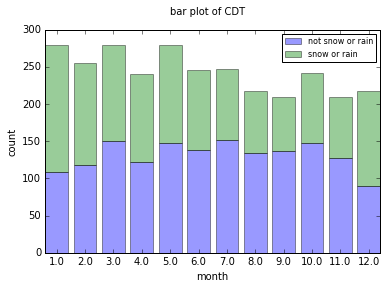

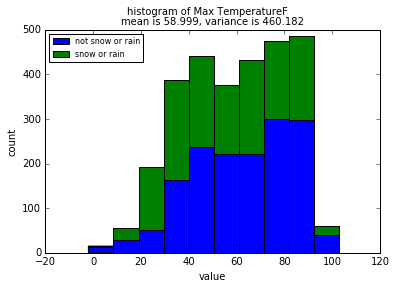

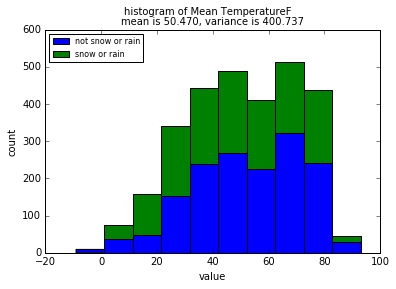

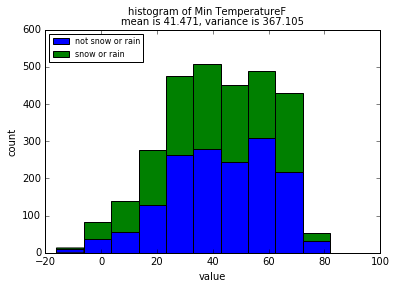

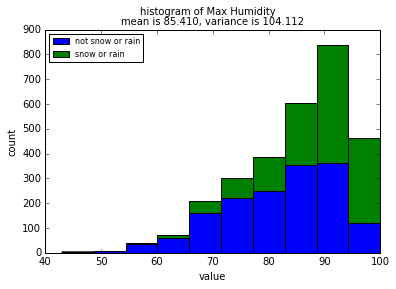

In [ ]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

def draw_hist(data,feature_name):
	fig = plt.figure()
	y = []
	y.extend(data['0'])
	y.extend(data['1'])
	
	mean = np.mean(y)
	variance = np.var(y)

	x = []
	x.append(data['0'])
	x.append(data['1'])
	plt.hist(x,stacked = True, rwidth = 10, color = ['b', 'g'], label = ['not snow or rain', 'snow or rain'])
	plt.legend(loc = 2, fontsize = '8')
	plt.ylabel('count')
	plt.xlabel('value')
	fig.suptitle('histogram of %s' % feature_name)
	plt.title('mean is %0.3f, variance is %0.3f' %(mean, variance),fontsize = '10')
	plt.show()
	#plt.savefig(feature_name)
	plt.close(feature_name)


def draw_bar_label(array,feature_name):
	plt.figure()
	num = len(array)
	c = Counter(array)
	h = dict(c)
	x_pos = range(len(list(h.items())))
	x_num = [i for i in h.keys()]
	plt.xticks(x_pos,x_num)
	plt.bar(x_pos, [value/num for value in h.values()],align='center', alpha=0.4)
	plt.xlabel('%s (0 represent not snow or rain, 1 represent snow or rain)' %feature_name)
	plt.ylabel('frequency')
	plt.title(feature_name)
	#plt.savefig(feature_name)
	plt.show()
	plt.close()

def draw_bar(data,feature_name):
	fig = plt.figure()
	fig.suptitle('bar plot of %s' % feature_name)

	c0 = Counter(data['0'])
	h0 = dict(c0)
	c1 = Counter(data['1'])
	h1 = dict(c1)

    #let h0& h1 have the same length
	for k in h0:
		if not k in h1:
			h1[k] = 0
	for kk in h1:
		if not kk in h0:
			h0[k] = 1
	
	x_pos = range(len(list(h0.items())))
	x_num = [i for i in h0.keys()]
	plt.xticks(x_pos,x_num)
	p1 = plt.bar(x_pos, h0.values(),align='center', alpha=0.4,color = 'b')
	p2 = plt.bar(x_pos, h1.values(),align = 'center',alpha = 0.4, bottom = h0.values(),color = 'g')
	plt.ylabel('count')
	if feature_name == 'CDT':
		plt.legend((p1[0],p2[0]), ('not snow or rain', 'snow or rain'),fontsize = '8')
		plt.xlabel('month')
	if feature_name == ' CloudCover':
		plt.legend((p1[0],p2[0]), ('not snow or rain', 'snow or rain'),loc = 2,fontsize = '8')
		plt.xlabel('degree of cloud cover')
	#plt.savefig(feature_name)
	plt.show()
	plt.close()



def main():
	#load data
	file_object = open("collection.csv")
	file = []
	for lines in file_object:
		file.append(lines.strip('\n'))
	file_object.close()

	#get feature names
	names = file[0]
	name_list = names.split(',')

	#get each features data, stores in data[](list of dict)
	#store the result of labels in label[](just a list)
	data=[]
	label = []
	for j in range(0,10):
		data.append({'0':[], '1':[]})
	for i in range(1,len(file)):
		strings = file[i].split(',')
		label.append(int(strings[10]))
		for index in range(0,10):
			if strings[10] == '0':
				data[index]['0'].append(float(strings[index]))
			else:
				data[index]['1'].append(float(strings[index]))

	bar_list = [0,9,10]

	for n in range(0,len(name_list)):
		if n in bar_list:
			if n == 10:
				draw_bar_label(label, name_list[n])
			else:
				dic = data[n]
				draw_bar(dic,name_list[n])

		else:
			feature_name = name_list[n]
			dic = data[n]
			draw_hist(dic,feature_name)

if __name__ == '__main__':
	main()
